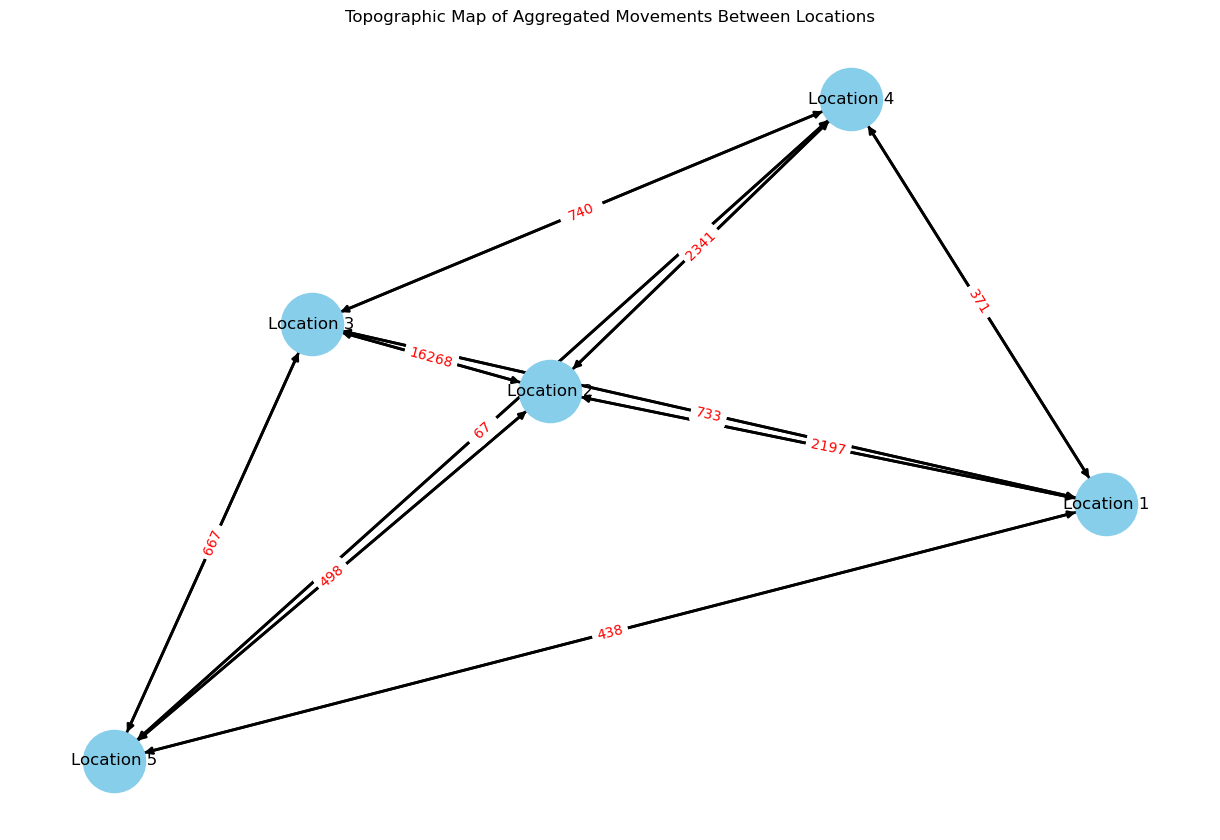

Aggregated movement report has been saved to 'aggregated_movement_report.txt'
Aggregated Movements Between Locations
    From Location 1 to Location 2 on 2024-05-28 17:10:00: 2197 times
    From Location 2 to Location 3 on 2024-05-28 17:10:00: 16320 times
    From Location 3 to Location 4 on 2024-05-28 17:10:00: 1227 times
    From Location 4 to Location 3 on 2024-05-28 17:10:00: 740 times
    From Location 3 to Location 2 on 2024-05-28 17:11:00: 16268 times
    From Location 2 to Location 1 on 2024-05-28 17:14:00: 2253 times
    From Location 1 to Location 3 on 2024-05-28 17:15:00: 733 times
    From Location 2 to Location 4 on 2024-05-28 17:15:00: 1883 times
    From Location 4 to Location 2 on 2024-05-28 17:16:00: 2341 times
    From Location 1 to Location 4 on 2024-05-28 18:15:00: 371 times
    From Location 3 to Location 1 on 2024-05-29 01:49:00: 445 times
    From Location 4 to Location 1 on 2024-06-03 21:00:00: 291 times
    From Location 2 to Location 5 on 2024-06-17 19:33:00: 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# Define the file path
file_path = r"C:\Users\ilan\OneDrive - pecit.ca\Wifi Analytics\May and June - 6.22_formatted.csv"

# Read only the first 727589 rows
df = pd.read_csv(file_path, nrows=727589)

# Process the data
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['date'] = df['timestamp'].dt.date  # Extract date from timestamp
df = df[['node_mac', 'client_mac', 'timestamp', 'date']]
df = df.sort_values(by='timestamp')

# Initialize a dictionary to store aggregated movement counts
movement_counts = {}

# Iterate through the data to count movements between node_macs
prev_node_mac = None
prev_timestamp = None
for index, row in df.iterrows():
    current_node_mac = row['node_mac']
    current_timestamp = row['timestamp']
    
    if prev_node_mac is not None and current_node_mac != prev_node_mac:
        if (prev_node_mac, current_node_mac) in movement_counts:
            movement_counts[(prev_node_mac, current_node_mac)]['count'] += 1
        else:
            movement_counts[(prev_node_mac, current_node_mac)] = {
                'count': 1,
                'timestamp': current_timestamp
            }
    
    prev_node_mac = current_node_mac
    prev_timestamp = current_timestamp

# Calculate total number of movements
total_movements = sum(count_data['count'] for count_data in movement_counts.values())

# Determine color thresholds based on proportions of the total movements
threshold_low = total_movements * 0.1
threshold_medium = total_movements * 0.3

# Prepare the results for plotting
output_data = []
for (from_node, to_node), count_data in movement_counts.items():
    output_data.append([
        from_node, to_node,
        count_data['count'], count_data['timestamp']
    ])

# Sort output_data in descending order based on the count
output_data.sort(key=lambda x: x[2], reverse=True)

output_df = pd.DataFrame(output_data, columns=['from_node', 'to_node', 'count', 'timestamp'])

# Initialize a directed graph
G = nx.DiGraph()

# Add edges with weights (count of movements)
for index, row in output_df.iterrows():
    G.add_edge(row['from_node'], row['to_node'], weight=row['count'])

# Extract unique node MAC addresses and create a mapping to new names
unique_nodes = df['node_mac'].unique()
node_name_mapping = {mac: f'Location {i+1}' for i, mac in enumerate(unique_nodes)}

# Rename the nodes in the graph
G = nx.relabel_nodes(G, node_name_mapping)

# Optional: Set positions for nodes (you can replace this with your actual coordinates)
pos = nx.spring_layout(G)

# Draw the graph with ordered edges
plt.figure(figsize=(12, 8))

# Set a fixed width for all edges
fixed_width = 2.0
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, width=fixed_width, arrows=True)

# Draw edge labels (weights)
edge_labels = {edge: G[edge[0]][edge[1]]['weight'] for edge in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

plt.title('Topographic Map of Aggregated Movements Between Locations')
plt.show()

# Generate a written report of the movements
report = []
report.append(f"\033[1mAggregated Movements Between Locations\033[0m")  # Bold title

for (from_node, to_node), count_data in movement_counts.items():
    count = count_data['count']
    timestamp = count_data['timestamp']
    
    # Determine color based on count proportions
    if count <= threshold_low:
        color_code = 221  # Light yellow
    elif count <= threshold_medium:
        color_code = 202  # Orange
    else:
        color_code = 196  # Red
    
    # Use the mapping to get new node names
    from_node_name = node_name_mapping[from_node]
    to_node_name = node_name_mapping[to_node]
    
    # Format the colored movement entry
    colored_movement = f"    \033[38;5;{color_code}mFrom {from_node_name} to {to_node_name} on {timestamp}: {count} times\033[0m"
    report.append(colored_movement)

# Save the report to a text file
with open('aggregated_movement_report.txt', 'w') as f:
    f.write('\n'.join(report))

print("Aggregated movement report has been saved to 'aggregated_movement_report.txt'")

# Print the report to the console
for line in report:
    print(line)